In [1]:
from xmitgcm import open_mdsdataset
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
from dask.diagnostics import ProgressBar
%matplotlib inline

In [2]:
ddir = '/vega/physo/users/jb3210/tracer_model/run_test_KOC_PSI/'

In [30]:
ds_diag = open_mdsdataset(ddir, prefix=['tracer_diags'], delta_t=900, ref_date='1993-01-01')
ds_snap = open_mdsdataset(ddir, prefix=['tracer_snapshots'], delta_t=900, ref_date='1993-01-01')

/u/6/r/ra2697/.conda/envs/xmitgcm_env/lib/python3.5/site-packages/xmitgcm/utils.py:192: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)


In [31]:
# relabel variables that are incorrectly placed at cell center
DXSqTr01 = xr.DataArray(ds_diag.DXSqTr01.data, dims=ds_diag.UVEL.dims, coords=ds_diag.UVEL.coords)
DYSqTr01 = xr.DataArray(ds_diag.DYSqTr01.data, dims=ds_diag.VVEL.dims, coords=ds_diag.VVEL.coords)

In [32]:
q2_int = (ds_snap.TRAC01**2 * ds_snap.rA).sum(dim=['i', 'j'])
with ProgressBar():
    q2_int.load()

/u/6/r/ra2697/.conda/envs/xmitgcm_env/lib/python3.5/site-packages/dask/array/core.py:2332: RuntimeWarning: overflow encountered in multiply
  dt = op(*vals).dtype


[########################################] | 100% Completed |  3.8s


In [33]:
grad_q2_int = ((DXSqTr01 * ds_diag.rAw * ds_diag.hFacW).sum(dim=['i_g', 'j']) +
               (DYSqTr01 * ds_diag.rAs * ds_diag.hFacS).sum(dim=['i', 'j_g']))
with ProgressBar():
    grad_q2_int.load()

[########################################] | 100% Completed |  7.4s


In [34]:
DT = 900 * 2688
delta_q2 = q2_int.diff('time', label='upper')
delta_q2 = delta_q2.where(delta_q2<0)
k = -0.5*delta_q2 / (DT * grad_q2_int)

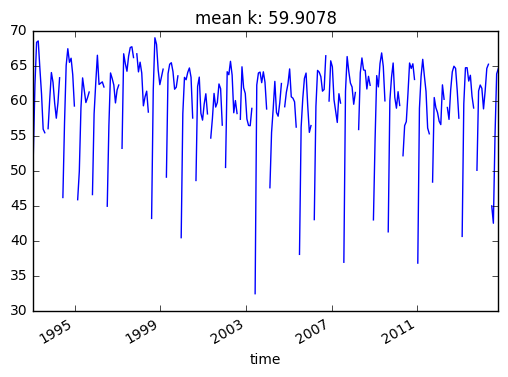

In [36]:
k.plot()
plt.title('mean k: %g' % k.mean())